# Implementation of backpropagation

## Imports

In [347]:
import math
import random
from graphviz import Digraph

## Value Class

The `Value` class represents a single value in the computation graph with the following properties:

- `data`: the numerical value,
- `grad`: the gradient (initially set to 0),
- `_backward`: a function for backpropagation to compute the gradient,
- `_prev`: a set of parent nodes in the computation graph,
- `operator`: the operator that created the value,
- `label`: a label describing the value.

### Mathematical operations
Basic mathematical operations (`+`, `*`, `-`, `/`, `**`) for `Value` objects. Each operation:

- Creates a new `Value` object,
- Defines the `backward` function, which computes the gradient of the parents based on differentiation rules.
### Activation Funcions

These methods implement common activation functions:

- `exp`: the exponential function,
- `tanh`: the hyperbolic tangent function,
- `sigmoid`: the sigmoid function. 
Each of these functions creates a new `Value` object and implements the `backward` function, which computes the gradient using the respective differentiation rule.

In [348]:
class Value:
  def __init__(self, data, _children=(),_operator='',label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self.operator = _operator
    self.label = label
  ##########################################
  def __repr__(self):
    return f"Value(data={self.data})"
  ##########################################
  def __add__(self,other): # self+other
    other = other if isinstance(other, Value) else Value(other)
    result = Value(self.data + other.data, (self, other), "+")

    def _backward_add():
      self.grad += 1.0 * result.grad
      other.grad += 1.0 * result.grad
    result._backward = _backward_add
    return result
  ##########################################
  def __radd__(self, other): # handle the case when the left operand is not a Value object
    return self.__add__(other)
  ##########################################
  def __neg__(self): # -self
    return self.__mul__(-1)
  ##########################################
  def __sub__(self, other): # self-other
    return self + (-other)
  ##########################################
  def __mul__(self, other): # self*other
    other = other if isinstance(other, Value) else Value(other)
    result = Value(self.data * other.data, (self, other), "*")

    def _backward_mul():
      self.grad += other.data * result.grad
      other.grad += self.data * result.grad
    result._backward = _backward_mul
    return result
  ##########################################
  def __rmul__(self, other): # handle the case when the left operand is not a Value object
    return self.__mul__(other)
  ##########################################
  def __pow__(self, other): # self**other
    assert isinstance(other, (int, float)), "only support int or float for now"
    result = Value(self.data ** other, (self,), f"**{other}")

    def _backward_pow():
      self.grad += other * (self.data ** (other - 1)) * result.grad

    result._backward = _backward_pow
    return result
  ##########################################
  def __truediv__(self, other): # self/other
    return self * other ** -1
  ##########################################
  def exp(self):
    x = self.data
    result = Value(math.exp(x), (self,), "exp")

    def _backward_exp():
      self.grad += result.data * result.grad
    result._backward = _backward_exp
    return result
  ##########################################
  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+ 1)
    result = Value(t, (self,), "tanh")

    def _backward_tanh():
      self.grad += (1-t**2)*result.grad
    result._backward = _backward_tanh
    return result
  ##########################################
  def sigmoid(self):
    x = self.data
    s = 1/(1+math.exp(-x))
    result = Value(s, (self,), "sigmoid")
     
    def _backward_sigmoid():
      self.grad += s*(1-s)*result.grad
    result._backward = _backward_sigmoid
    return result
  ##########################################
  def relu(self):
    x = self.data
    r = max(0,x)
    result = Value(r, (self,), "relu")

    def _backward_relu():
      self.grad += (x>0)*result.grad
    result._backward = _backward_relu
    return result  
  ##########################################
  def activation(self, act):
    if act == 'relu':
      return self.relu()
    elif act == 'sigmoid':
      return self.sigmoid()
    elif act == 'tanh':
      return self.tanh()
    else:
      raise ValueError(f"Unknown activation function: {act}")
  ##########################################
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0 # set the gradient of the base case

    for node in reversed(topo):
      node._backward()

## Visualization


 These functions are used to visualize the computation graph. 
 - The `trace` function generates the nodes and edges of the graph.
 - The `draw_dot` function creates a graphical representation using Graphviz.

In [349]:
def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  nodes, edges = trace(root)
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #Left to Right

  for node in nodes:
    uid = str(id(node))
    dot.node(name = uid, label=f"{node.label} | data {node.data:.4f} | grad {node.grad:.4f}", shape='record')
    if node.operator:
      # if this value is created by an operator, create an operator node for it
      dot.node(name = uid + node.operator, label=node.operator,)
      #connect this node to it
      dot.edge(uid + node.operator, uid)
  for n1, n2 in edges:
    #connect n1 to the operator node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.operator)

  return dot

## Example: Computing Gradients for Activation Function

In this example, we create input variables x1, x2, and weights and biases (w1, w2, b). We then compute the output of the neuron and perform backpropagation using the backward method.

In [350]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
b = Value(6.88137, label='b')
# x1*w1 + x2*w2 + b
w1x1 = w1*x1; w1x1.label='w1*x1'
w2x2 = w2*x2; w2x2.label='w2*x2'
x1w1x2w2 = w1x1 + w2x2; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2 + b; n.label='n' # neuron
o = n.tanh(); o.label='o' # activation function

In [351]:
o.backward()

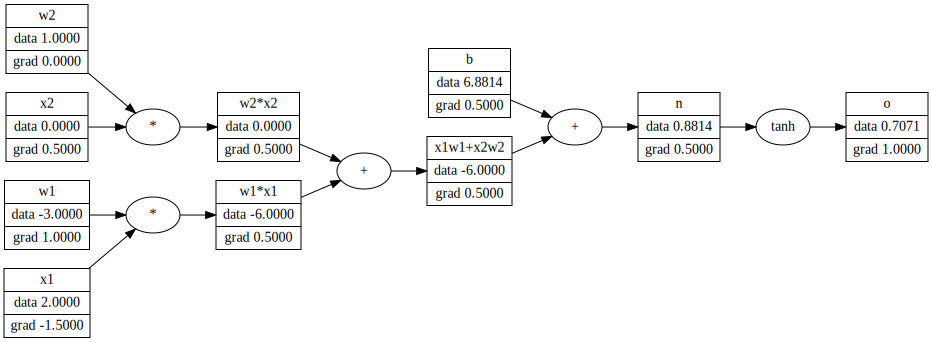

In [352]:
draw_dot(o)

tanh activation function written by hand should have the same result as the one declared above but on the graph it should show all the steps

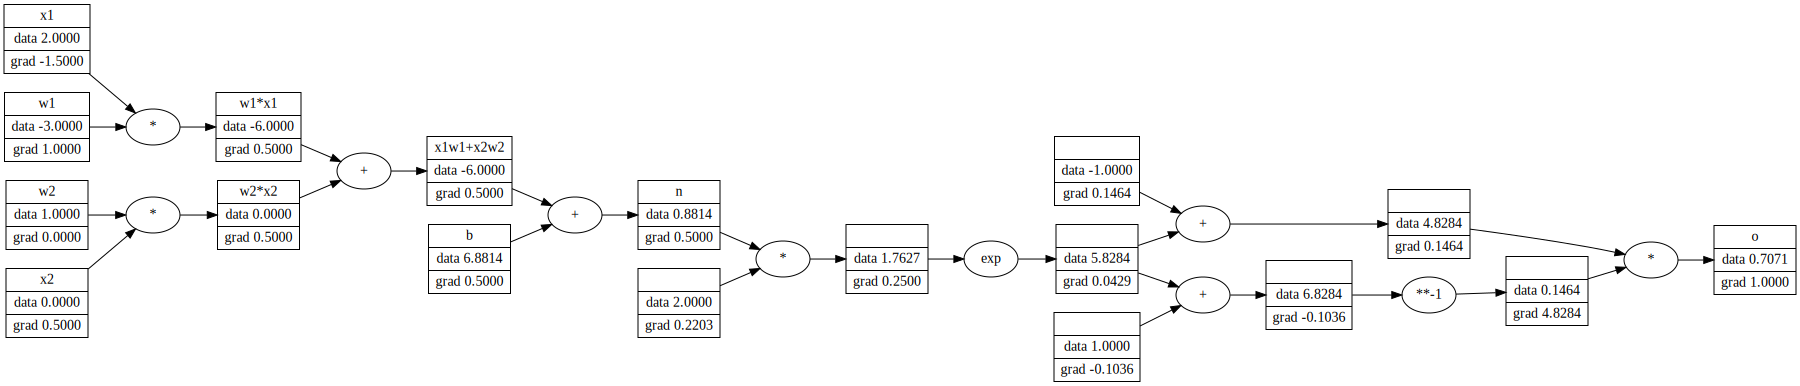

In [353]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
b = Value(6.88137, label='b')
# x1*w1 + x2*w2 + b
w1x1 = w1*x1; w1x1.label='w1*x1'
w2x2 = w2*x2; w2x2.label='w2*x2'
x1w1x2w2 = w1x1 + w2x2; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2 + b; n.label='n' # neuron
##############################################
e = (2*n).exp()
o = (e-1)/(e+1)
##############################################
o.label = 'o'
o.backward()
draw_dot(o)


## Example in Pytorch

An example in PyTorch that demonstrates similar operations using built-in PyTorch functions. We create tensors, enable gradient tracking (`requires_grad=True`), perform computations, and compute gradients using `backward`.

In [354]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())
print('x2', x2.grad.item())


0.7071050214706146
-----
x1 -1.500007465833125
w1 1.0000049772220834
w2 0.0
x2 0.5000024886110417


## Creating Multi layer perceptron(MLP)

Classes below implement the structure of a multi-layer perceptron (MLP). The `Neuron` class represents a single neuron, the `Layer` class represents a layer of neurons, and the `MLP` class represents the entire network. Each layer and neuron has its parameters, which are trained using a gradient-based algorithm.

In [387]:
class Neuron:
  def __init__(self, nin, activation_fun):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))
    self.activation_fun = activation_fun
    
  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    result = act.activation(self.activation_fun)
    return result 
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout, activation_fun):
    self.neurons = [Neuron(nin, activation_fun) for _ in range(nout)]

  def __call__(self, x):
    outs = [neuron(x) for neuron in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [param for neuron in self.neurons for param in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts, activation_fun):
    sizes = [nin] + nouts
    self.layers = [Layer(sizes[i], sizes[i+1], activation_fun) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
        x = layer(x)
    return x
  
  def parameters(self):
    return [param for layer in self.layers for param in layer.parameters()]


In [389]:
x = [2.0, 3.0, 4.0]
# 1 input layer -> 2 hidden layers -> 1 output layer
# # 3 inputs -> 4 neurons -> 4 neurons -> 1 output
# 41 parameters -> 4 + 4 + 1 (biases) + 4*3 + 4*4 + 4*1 (weights) = 41 
n = MLP(3, [4, 4, 1], activation_fun='tanh')
n(x)

Value(data=-0.3713278330866898)

In [390]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] #desired outputs

### Loss Calculation and Backpropagation

We compute the loss based on the difference between predictions and ground truth values. We then perform backpropagation to update the gradients.

In [395]:
for k in range(200):
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  #backward pass
  for param in n.parameters():
    param.grad = 0.0
  loss.backward()

  #update
  for param in n.parameters():
    param.data -= 0.001 * param.grad

  print(k, loss.data)

0 0.07474808561261626
1 0.07456293460492532
2 0.07437862949107472
3 0.07419516471169274
4 0.07401253475477891
5 0.07383073415521012
6 0.0736497574942521
7 0.0734695993990783
8 0.07329025454229254
9 0.07311171764146054
10 0.07293398345864377
11 0.0727570467999415
12 0.07258090251503752
13 0.07240554549675204
14 0.0722309706805997
15 0.07205717304435229
16 0.07188414760760739
17 0.07171188943136182
18 0.07154039361758992
19 0.07136965530882786
20 0.07119966968776184
21 0.07103043197682216
22 0.07086193743778113
23 0.0706941813713568
24 0.07052715911682096
25 0.0703608660516113
26 0.07019529759094939
27 0.0700304491874616
28 0.0698663163308063
29 0.06970289454730355
30 0.0695401793995708
31 0.06937816648616177
32 0.06921685144121031
33 0.06905622993407778
34 0.068896297669005
35 0.06873705038476818
36 0.06857848385433873
37 0.06842059388454708
38 0.0682633763157504
39 0.06810682702150445
40 0.06795094190823858
41 0.0677957169149353
42 0.06764114801281246
43 0.06748723120501068
44 0.067333

In [396]:
ypred

[Value(data=0.9036588862949803),
 Value(data=-0.9322072463717727),
 Value(data=-0.8721874736101723),
 Value(data=0.8611011408868585)]